In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

In [2]:
bureau_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau_balance.csv')
help_tool.first_look(bureau_balance)

Dataset has 27299925 observations and 3 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_BUREAU,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
STATUS,object,0,0.0


In [3]:
def bureau_balance_data_clean(df):
    df['STATUS'] = df['STATUS'].replace({'C': -1, 'X': np.nan}).astype(float)
    df['STATUS'] = df['STATUS'].infer_objects(copy=False)
    return df

bureau_balance_data_clean(bureau_balance)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,-1.0
1,5715448,-1,-1.0
2,5715448,-2,-1.0
3,5715448,-3,-1.0
4,5715448,-4,-1.0
...,...,...,...
27299920,5041336,-47,NaN
27299921,5041336,-48,NaN
27299922,5041336,-49,NaN
27299923,5041336,-50,NaN


The values in the STATUS column can be interpreted as follows:

0: No DPD (Days past due)</br>
1: DPD 1-30 days</br>
2: DPD 31-60 days</br>
3: DPD 61-90 days</br>
4: DPD 91-120 days</br>
5: DPD 121+ days</br>
C: Closed</br>
X: No loan for the month</br>

In [4]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5715448]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,-1.0
1,5715448,-1,-1.0
2,5715448,-2,-1.0
3,5715448,-3,-1.0
4,5715448,-4,-1.0
5,5715448,-5,-1.0
6,5715448,-6,-1.0
7,5715448,-7,-1.0
8,5715448,-8,-1.0
9,5715448,-9,0.0


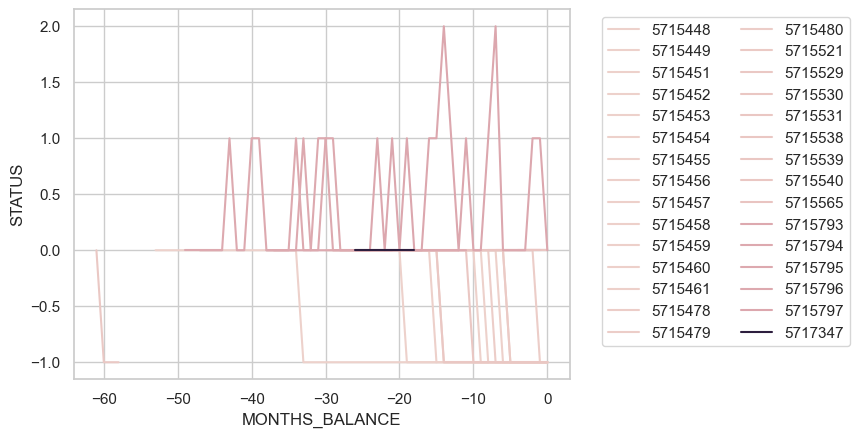

In [5]:
first_100_ids = bureau_balance['SK_ID_BUREAU'].drop_duplicates().head(30)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(first_100_ids)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE', y='STATUS', hue='SK_ID_BUREAU', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

In [6]:
bureau_balance_sample = bureau_balance.sample(n=100000, random_state=42)

MONTHS_BALANCE


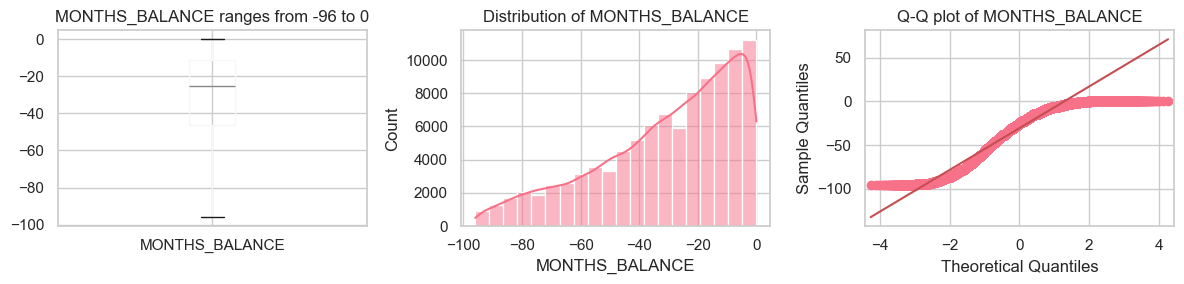

STATUS


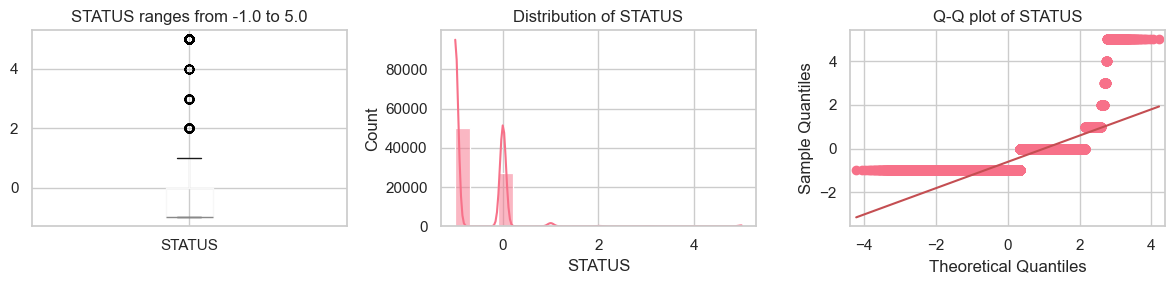

In [7]:
help_visuals.distribution_check(bureau_balance_sample[['MONTHS_BALANCE', 'STATUS']])

STATUS


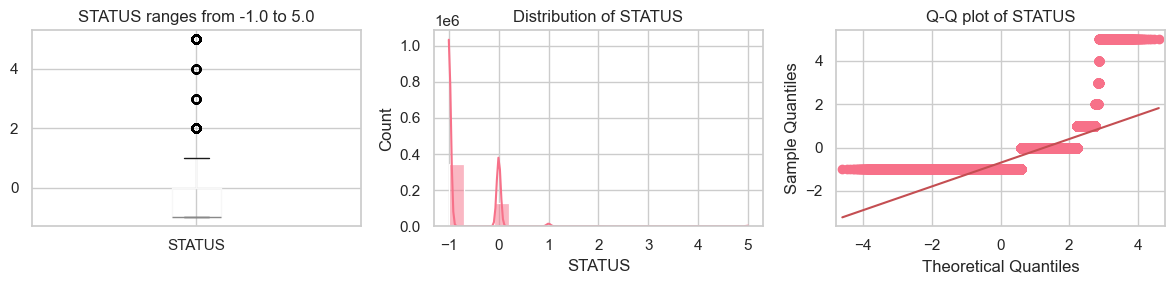

In [8]:
help_visuals.distribution_check(bureau_balance[bureau_balance['MONTHS_BALANCE'] == 0][['STATUS']])

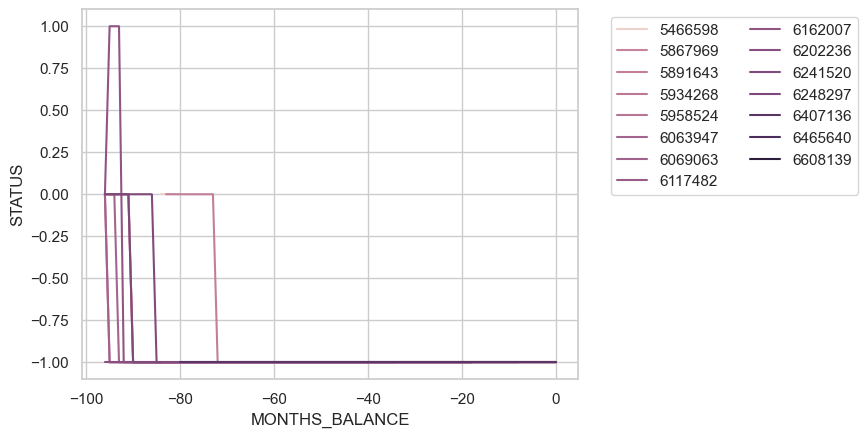

In [9]:
long_term_users = bureau_balance[bureau_balance['MONTHS_BALANCE'] == bureau_balance['MONTHS_BALANCE'].min()]['SK_ID_BUREAU'].drop_duplicates().sample(15, random_state=42)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(long_term_users)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE', y='STATUS', hue='SK_ID_BUREAU', legend='full'
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

# bureau

In [10]:
bureau = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau.csv')
help_tool.first_look(bureau)

Dataset has 1716428 observations and 17 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
SK_ID_BUREAU,int64,0,0.0
CREDIT_ACTIVE,object,0,0.0
CREDIT_CURRENCY,object,0,0.0
DAYS_CREDIT,int64,0,0.0
CREDIT_DAY_OVERDUE,int64,0,0.0
DAYS_CREDIT_ENDDATE,float64,105553,6.1
DAYS_ENDDATE_FACT,float64,633653,36.9
AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.5
CNT_CREDIT_PROLONG,int64,0,0.0


In [11]:
object_col = bureau.select_dtypes(include=['object']).columns.tolist()

for feature in bureau.select_dtypes(include=['object']).columns.tolist():
    print(bureau[feature].value_counts(), '\n')

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64 

CREDIT_CURRENCY
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: count, dtype: int64 

CREDIT_TYPE
Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile

In [12]:
def bureau_clean(df):
    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].str.lstrip('currency ').astype(int)
    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].infer_objects(copy=False)

bureau_clean(bureau)

In [13]:
bureau[bureau['CREDIT_ACTIVE'] != 'Active']

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
7,162297,5714469,Closed,1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0,0.0,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.0,0.0,0.0,Consumer credit,-840,NaN
11,162297,5714473,Closed,1,-2456,0,-629.0,-825.0,NaN,0,675000.00,0.0,0.0,0.0,Consumer credit,-706,NaN
14,238881,5714482,Closed,1,-318,0,-187.0,-187.0,NaN,0,0.00,0.0,0.0,0.0,Credit card,-185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716422,375755,5057742,Closed,1,-2648,0,31129.0,-189.0,NaN,0,202500.00,0.0,NaN,0.0,Credit card,-109,NaN
1716424,100044,5057754,Closed,1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [14]:
bureau_balance[bureau_balance['MONTHS_BALANCE'] == 0]['STATUS'].max()

5.0

In [15]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,-1.0
1,5715448,-1,-1.0
2,5715448,-2,-1.0
3,5715448,-3,-1.0
4,5715448,-4,-1.0
...,...,...,...
27299920,5041336,-47,NaN
27299921,5041336,-48,NaN
27299922,5041336,-49,NaN
27299923,5041336,-50,NaN


In [16]:
bureau_balance_ids = bureau_balance['SK_ID_BUREAU'].drop_duplicates().to_frame()

In [17]:
bureau_balance_ids.shape

(817395, 1)

In [18]:
duckdb.query("""
WITH shape AS (
    SELECT DISTINCT A.SK_ID_BUREAU AS A_SK_ID_BUREAU, B.SK_ID_BUREAU AS B_SK_ID_BUREAU
    FROM bureau A 
    LEFT JOIN bureau_balance B
    ON A.SK_ID_BUREAU = B.SK_ID_BUREAU
)
SELECT 
    SUM(CASE WHEN B_SK_ID_BUREAU IS NULL THEN 1 ELSE 0 END) AS NULL_VAL,
    SUM(CASE WHEN B_SK_ID_BUREAU IS NOT NULL THEN 1 ELSE 0 END) AS NOT_NULL_VAL
FROM shape
""").df()


,NULL_VAL,NOT_NULL_VAL
0,942074.0,774354.0


In [19]:
bureau_balance_gr = duckdb.query("""
             WITH 

             bureau_balance_grouped as (
                SELECT 
                     SK_ID_BUREAU, 
                     MIN(MONTHS_BALANCE) - MAX(MONTHS_BALANCE) AS History_Lenght_Month, 
                     SUM(CASE WHEN STATUS = 1 THEN 1 ELSE 0 END) AS ONE_MONTHS_MISSED_COUNT,
                     SUM(CASE WHEN STATUS = 2 THEN 1 ELSE 0 END) AS TWO_MONTHS_MISSED_COUNT,
                     SUM(CASE WHEN STATUS = 3 THEN 1 ELSE 0 END) AS TREE_MONTHS_MISSED_COUNT,
                     SUM(CASE WHEN STATUS = 4 THEN 1 ELSE 0 END) AS FOUR_MONTHS_MISSED_COUNT,
                     SUM(CASE WHEN STATUS = 5 THEN 1 ELSE 0 END) AS FIVE_MONTHS_MISSED_COUNT,
                     SUM(CASE WHEN STATUS > 0 THEN 1 ELSE 0 END) AS MONTHS_MISSED_COUNT          
             
                FROM bureau_balance
                GROUP BY SK_ID_BUREAU
             )


             SELECT * 
             FROM bureau A 
             LEFT JOIN bureau_balance_grouped B
             ON A.SK_ID_BUREAU = B.SK_ID_BUREAU


              """).df()

In [20]:
bureau_balance_gr

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_BUREAU_1,History_Lenght_Month,ONE_MONTHS_MISSED_COUNT,TWO_MONTHS_MISSED_COUNT,TREE_MONTHS_MISSED_COUNT,FOUR_MONTHS_MISSED_COUNT,FIVE_MONTHS_MISSED_COUNT,MONTHS_MISSED_COUNT
0,275511,5004358,Closed,1,-658,0,-293.0,-324.0,NaN,0,...,-14,NaN,5004358.0,-21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,286870,5715701,Closed,1,-2157,0,-1421.0,-1421.0,NaN,0,...,-1413,6210.0,5715701.0,-70.0,1.0,0.0,0.0,0.0,0.0,1.0
2,391046,5717376,Active,1,-1924,0,-1743.0,NaN,0.000,0,...,-84,7762.5,5717376.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0
3,359372,5718550,Active,1,-1238,0,907.0,NaN,NaN,0,...,-25,NaN,5718550.0,-40.0,0.0,0.0,0.0,0.0,0.0,0.0
4,212690,5718647,Closed,1,-936,0,-390.0,-390.0,4561.560,0,...,-390,NaN,5718647.0,-30.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,266701,5055155,Closed,1,-1555,0,-885.0,-868.0,NaN,0,...,-772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716424,203220,5057265,Closed,1,-734,0,-229.0,-229.0,0.000,0,...,-228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716425,200106,5057431,Closed,1,-2554,0,-2431.0,-2459.0,130.275,0,...,-2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716426,232638,5057553,Active,1,-613,0,721.0,NaN,NaN,0,...,-42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
bureau_balance_gr.dtypes

SK_ID_CURR                    int64
SK_ID_BUREAU                  int64
CREDIT_ACTIVE                object
CREDIT_CURRENCY               int32
DAYS_CREDIT                   int64
CREDIT_DAY_OVERDUE            int64
DAYS_CREDIT_ENDDATE         float64
DAYS_ENDDATE_FACT           float64
AMT_CREDIT_MAX_OVERDUE      float64
CNT_CREDIT_PROLONG            int64
AMT_CREDIT_SUM              float64
AMT_CREDIT_SUM_DEBT         float64
AMT_CREDIT_SUM_LIMIT        float64
AMT_CREDIT_SUM_OVERDUE      float64
CREDIT_TYPE                  object
DAYS_CREDIT_UPDATE            int64
AMT_ANNUITY                 float64
SK_ID_BUREAU_1              float64
History_Lenght_Month        float64
ONE_MONTHS_MISSED_COUNT     float64
TWO_MONTHS_MISSED_COUNT     float64
TREE_MONTHS_MISSED_COUNT    float64
FOUR_MONTHS_MISSED_COUNT    float64
FIVE_MONTHS_MISSED_COUNT    float64
MONTHS_MISSED_COUNT         float64
dtype: object

# Light XGB

In [42]:
bureau_balance_gr['CREDIT_ACTIVE'].value_counts() / bureau_balance_gr['CREDIT_ACTIVE'].value_counts().max() * 100

CREDIT_ACTIVE
Closed      100.000000
Active       58.428868
Sold          0.604759
Bad debt      0.001946
Name: count, dtype: float64

In [44]:
#bureau_balance_gr[bureau_balance_gr['CREDIT_ACTIVE'].isin(['Sold', 'Bad debt'])]

In [46]:
bureau_balance_gr[(bureau_balance_gr['CREDIT_ACTIVE'] != 'Active') & (~bureau_balance_gr['MONTHS_MISSED_COUNT'].isna())]['CREDIT_ACTIVE'].value_counts() /489622 * 100

CREDIT_ACTIVE
Closed      100.000000
Sold          0.598625
Bad debt      0.000613
Name: count, dtype: float64

In [82]:
bureau_bad_sold = bureau_balance_gr[bureau_balance_gr['CREDIT_ACTIVE'] != 'Active'].drop(columns=['SK_ID_CURR', 'SK_ID_BUREAU'])

bureau_bad_sold.loc[bureau_bad_sold['CREDIT_ACTIVE'] == 'Closed', 'CREDIT_Bad_Sold'] = 0
bureau_bad_sold.loc[bureau_bad_sold['CREDIT_ACTIVE'] != 'Closed', 'CREDIT_Bad_Sold'] = 1

bureau_bad_sold.drop(columns=['CREDIT_ACTIVE', 'DAYS_ENDDATE_FACT'], inplace=True)

In [83]:
bureau_bad_sold['CREDIT_Bad_Sold'].value_counts()

CREDIT_Bad_Sold
0.0    1079273
1.0       6548
Name: count, dtype: int64

In [84]:
y = bureau_bad_sold['CREDIT_Bad_Sold']
X = bureau_bad_sold.drop(columns=['CREDIT_Bad_Sold'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

# Define the model
model = LGBMClassifier(**params, n_estimators=100)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [86]:
# # Evaluate the model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Precision: {precision}")
print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"ROC AUC: {roc_auc}")


Precision: 0.7082352941176471
accuracy: 0.9955379550111666
recall: 0.455026455026455
ROC AUC: 0.9811797592095217


In [87]:
# Extract the preprocessing step and get feature names
preprocessor.fit(X_train)
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = numerical_features + onehot_columns.tolist()

# Extract feature importances from the trained model
feature_importances = model.feature_importances_

# Combine feature names and their importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': all_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                              Feature  Importance
10                                 DAYS_CREDIT_UPDATE         598
3                                 DAYS_CREDIT_ENDDATE         538
6                                      AMT_CREDIT_SUM         345
1                                         DAYS_CREDIT         331
4                              AMT_CREDIT_MAX_OVERDUE         294
7                                 AMT_CREDIT_SUM_DEBT         151
11                                        AMT_ANNUITY         109
13                               History_Lenght_Month         105
8                                AMT_CREDIT_SUM_LIMIT         101
18                           FIVE_MONTHS_MISSED_COUNT          65
12                                     SK_ID_BUREAU_1          59
2                                  CREDIT_DAY_OVERDUE          50
21                               CREDIT_TYPE_Car loan          37
19                                MONTHS_MISSED_COUNT          35
23        

In [88]:
bureau_balance_gr

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_BUREAU_1,History_Lenght_Month,ONE_MONTHS_MISSED_COUNT,TWO_MONTHS_MISSED_COUNT,TREE_MONTHS_MISSED_COUNT,FOUR_MONTHS_MISSED_COUNT,FIVE_MONTHS_MISSED_COUNT,MONTHS_MISSED_COUNT
0,275511,5004358,Closed,1,-658,0,-293.0,-324.0,NaN,0,...,-14,NaN,5004358.0,-21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,286870,5715701,Closed,1,-2157,0,-1421.0,-1421.0,NaN,0,...,-1413,6210.0,5715701.0,-70.0,1.0,0.0,0.0,0.0,0.0,1.0
2,391046,5717376,Active,1,-1924,0,-1743.0,NaN,0.000,0,...,-84,7762.5,5717376.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0
3,359372,5718550,Active,1,-1238,0,907.0,NaN,NaN,0,...,-25,NaN,5718550.0,-40.0,0.0,0.0,0.0,0.0,0.0,0.0
4,212690,5718647,Closed,1,-936,0,-390.0,-390.0,4561.560,0,...,-390,NaN,5718647.0,-30.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,266701,5055155,Closed,1,-1555,0,-885.0,-868.0,NaN,0,...,-772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716424,203220,5057265,Closed,1,-734,0,-229.0,-229.0,0.000,0,...,-228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716425,200106,5057431,Closed,1,-2554,0,-2431.0,-2459.0,130.275,0,...,-2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716426,232638,5057553,Active,1,-613,0,721.0,NaN,NaN,0,...,-42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
